In [1]:
# Need to scale problem better
# Need to include the cost function

In [2]:
%reset # clears variables in workspace

# import libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

# import EOM
import dill
dill.load_session('simplified_biped.db')

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] + [LL] +\
           [masses[base] for base in bases] +\
           [masses[link,leg] for leg in legs for link in links] +\
           [lengths[base] for base in bases] +\
           [lengths[link,leg] for leg in legs for link in links] +\
           [inertias[base] for base in bases] +\
           [inertias[link,leg] for leg in legs for link in links] +\
           [x_body]+[y_body]+[th_body]+[th_disc] + [th[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [dx_body]+[dy_body]+[dth_body]+[dth_disc] + [dth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [ddx_body]+[ddy_body]+[ddth_body]+[ddth_disc] + [ddth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [tau['disc']]+\
           [tau['left',leg] for leg in legs] + [tau['right',leg] for leg in legs] +\
           [lamda['x',leg] for leg in legs] + [lamda['y',leg] for leg in legs] +\
           [GRF['x',leg] for leg in legs] + [GRF['y',leg] for leg in legs]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body'] +['theta_body'] + ['theta_disc']

for leg in legs:
    for link in links:
        if 'foot' not in link:
            DOFs = DOFs + ['theta_{0}'.format(link+leg)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})

    
# PARAMETERS:
masses_ = {'body': 5756.78/1000,
           'disc': (485/1000) + (800/1000), # motor + disc
           'ullA': 153.81/1000,
           'lllA': 346.45/1000,
           'urlA': 153.81/1000,
           'lrlA': 346.45/1000,
           'ullB': 153.81/1000,
           'lllB': 346.45/1000,
           'urlB': 153.81/1000,
           'lrlB': 346.45/1000}

lengths_ = {'body': 24/100,
            'disc': None,
            'ullA': 17.5/100,
            'lllA': 30.0/100,
            'urlA': 17.5/100,
            'lrlA': 30.0/100,
            'ullB': 17.5/100,
            'lllB': 30.0/100,
            'urlB': 17.5/100,
            'lrlB': 30.0/100}

''' ****** '''
disc_radius = 0.5*lengths_['ullA']

inertias_ = {'body': 32124078.52*1e-9, # body rotate about its center 
             'disc': 0.5*masses_['disc']*(disc_radius**2)
            'ullA': 600933.68*1e-9, # rotates as pendulumn 
            'urlA': 600933.68*1e-9,
            'lllA': 4659658.63*1e-9,
            'lrlA': 4659658.63*1e-9,
            'ullB': 600933.68*1e-9, # rotates as pendulumn 
            'urlB': 600933.68*1e-9,
            'lllB': 4659658.63*1e-9,
            'lrlB': 4659658.63*1e-9}

total_mass = 0.0
for mass in masses_:
    total_mass += masses_[mass]
total_mass

WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
legs = ['A','B']
links = ['ull','lll','url','lrl']
bases = ['body','disc']
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'ull' ,'right': 'url'}
all_links = []
for leg in legs:
    for link in links:
        all_links.append(link+leg)
        
[all_links.append(base) for base in bases]

def get_var_list_zeros(m,n):
    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0]+\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    connection_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
    tau_value.update({('disc'):tau_torque_FW[n]})
    
    for leg in legs:
        
        [tau_value.update({(side,leg): BW*(m.tau_torque[n,side,leg])}) for side in sides]
        #[connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,'+ve',wdof,leg]-m.connect_force[n,'-ve',wdof,leg])}) for wdof in WDOFs]
        #[connection_force_value.update({(wdof,leg):0.0})for wdof in WDOFs]
        [connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,wdof,leg])}) for wdof in WDOFs]
        GRF_X_value.update({(leg):BW*(m.GRF_x[n,'+ve',leg]-m.GRF_x[n,'-ve',leg])})
        GRF_Y_value.update({(leg):BW*(m.GRF_y[n,leg])})

    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['disc']]+\
               [tau_value['left',leg] for leg in legs] + [tau_value['right',leg] for leg in legs] +\
               [connection_force_value['X',leg] for leg in legs] + [connection_force_value['Y',leg] for leg in legs] +\
               [GRF_X_value[leg] for leg in legs] + [GRF_Y_value[leg] for leg in legs]
    return var_list



Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details


--------------
Stall torque =  140.4238410596027
Max speed =  55.8
--------------


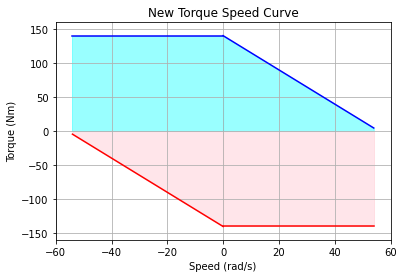

In [3]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
no_load_speed = 55.8
# from graph
max_torque = 38.0
speed_max_torque = 40.7

m_grad = (max_torque-0.0)/(speed_max_torque-no_load_speed)

stall_torque = 0.0 - m_grad*no_load_speed

y_p = m_grad*x_p+stall_torque
y_n = m_grad*x_n-stall_torque

stall_torque_p = []
stall_torque_n = []
rated_torque_p = []
rated_torque_n = []

for ii in range(len(x_p)):
    stall_torque_p.append(stall_torque)
    stall_torque_n.append(-stall_torque)
    rated_torque_p.append(max_torque)
    rated_torque_n.append(-max_torque)

plt.grid()
plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('--------------')

print('Stall torque = ',stall_torque)
print('Max speed = ',no_load_speed)

print('--------------')

In [ ]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt

no_load_speed_FW = 55.8
# from graph
max_torque_FW = 38.0
speed_max_torque_FW = 40.7

m_grad_FW = (max_torque_FW-0.0)/(speed_max_torque_FW-no_load_speed_FW)

stall_torque_FW = 0.0 - m_grad_FW*no_load_speed_FW

y_p_FW = m_grad_FW*x_p+stall_torque_FW
y_n_FW = m_grad_FW*x_n-stall_torque_FW

stall_torque_p_FW = []
stall_torque_n_FW = []
rated_torque_p_FW = []
rated_torque_n_FW = []

for ii in range(len(x_p)):
    stall_torque_p_FW.append(stall_torque_FW)
    stall_torque_n_FW.append(-stall_torque_FW)
    rated_torque_p_FW.append(max_torque_FW)
    rated_torque_n_FW.append(-max_torque_FW)

plt.grid()
plt.plot(x_p, y_p_FW,'b')
plt.plot(x_n, stall_torque_p_FW,'b')

plt.fill_between(x_p, y_p_FW, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p_FW, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n_FW,'r')
plt.plot(x_p, stall_torque_n_FW,'r')

plt.fill_between(x_n, y_n_FW, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n_FW, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('--------------')

print('Stall torque = ',stall_torque_FW)
print('Max speed = ',no_load_speed_FW)

print('--------------')

In [4]:
FOR_LOOP_RUN = False

<a id='Select_Test'></a>

In [5]:
tests = {0:"High_Drop_Test",1:"Low_Drop_Test", 2:"Hop_Test", 3:"Drop_Hop_Test",\
         4:"Standing_Test", 5:"Tax_Day_Sprint",6:"Missing_the_Boat",\
         7:"Periodic_Hop",8:"Periodic_Run",9:"Stop_Periodic_Run_Flight",10:"Start_Periodic_Run",\
         11:"High_Drop_Move_Leg", 12:"Forward_Hop", 13:"Stop_Periodic_Run_MidStance"}


test = tests[13]
V_avg = 8.0
mu_value = 1.0
h_lower_bound = 0.5
h_higher_bound = 1.0

if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test":
    N = 50
    TT = 0.2
elif test == "High_Drop_Move_Leg":
    N = 50
    TT = 0.4
elif test == "Forward_Hop":
    N = 50
    TT = 0.7
    x_final = 2.0 # for display
elif test == "Hop_Test" or test == "Drop_Hop_Test":
    N = 50
    TT = 1.0
elif test == "Tax_Day_Sprint":
    N = 50
    TT = 1.5
    x_final = 5.0
elif test == "Missing_the_Boat":
    N = 50
    TT = 1.0
    x_final = 5.0
elif test == "Periodic_Hop":
    N = 50
    TT = 1.0 # 2Hz but only half a gait due to symmetry
    dy_periodic = 0.5
elif test == "Periodic_Run":
    # u 0.5 [N = 100 and TT = 0.15 0.5<h<1.5]
    # u 1.0 [N = 100 and TT = 0.3 0.8<h<1.2]
    N = 50 #100
    TT = 0.15 #0.5 #0.3 # 2Hz but only half a gait due to symmetry
    V_flight = 0.75*sqrt(9.81*(0.18+0.35)) # from paper
    x_final = 3.0 # for display

elif test == "Stop_Periodic_Run_Flight" or test == "Start_Periodic_Run" or test == "Stop_Periodic_Run_MidStance":

    import csv
    file = open(str(round(V_avg))+'_u1.0.csv'.format(str(mu_value)))
    csvreader = csv.reader(file)

    rows = []
    for row in csvreader:
        rows.append(row)

    stored_values = {}
    headers = rows[0]

    for item in rows:
        if item[0] == 'node': # remove headers
            pass
        else: 
            for header_loc in range(len(headers)):
                if header_loc == 0: # don't want 'node' as header - only its value
                    pass 
                else:
                    stored_values.update({(headers[header_loc],int(item[0])):float(item[header_loc])})

        #initial_conditions[item[0]] = float(item[1])
    x_final = 5.0 # for display 

    if test == "Stop_Periodic_Run_Flight":
        # done [100,1.5 and ]
        N = 100 #50
        TT = 1.0 # 1.0 2Hz but only half a gait due to symmetry
    elif test == "Stop_Periodic_Run_MidStance":
        N = 100
        TT = 1.0
    elif test == "Start_Periodic_Run":
        N = 50
        TT = 1.0
    else: pass   

else:
    pass



In [6]:
GRF_yA_array = []
GRF_yB_array = []
for n in range (N):
    GRF_yA_array.append(stored_values['GRF_yA',n])
    GRF_yB_array.append(stored_values['GRF_yB',n])
    
print(max(GRF_yA_array))
print(max(GRF_yB_array))
max_GRFA = max(GRF_yA_array)
max_GRFB = max(GRF_yB_array)
max_index = GRF_yB_array.index(max(GRF_yB_array))
print(max_index)
midstance_node = max_index+1

0.0
761.042054619696
43


In [7]:
print("test = ",test)
print("total mass = " ,total_mass)
print("mu = ",mu_value)
print("V_avg = ",V_avg)
print("N = ",N)
print("TT = ",TT)

if TT/N < 0.01 or TT/N>0.02:
    print('Exceeded hm: ',TT/N)
else:
    print('Passed hm: ',TT/N)
    


test =  Stop_Periodic_Run_MidStance
total mass =  7.75782
mu =  1.0
V_avg =  8.0
N =  100
TT =  1.0
Passed hm:  0.01


In [8]:
m = ConcreteModel('Biped_wFW')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.legs = Set(initialize = legs)
m.links = Set(initialize = links)
m.bases = Set(initialize = bases)
m.all_links = Set(initialize = all_links)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)


#Params--------------------------
m.g = Param(initialize = 9.81)
m.LL = Param(initialize = 7.5/100)

# m.masses = Param(m.links, initialize = masses)
m.masses = Param(m.all_links, initialize = masses_)
m.lengths = Param(m.all_links, initialize = lengths_)
m.inertias = Param(m.all_links, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

In [9]:
''' CONSTRAINTS  - Integration'''
# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (h_lower_bound,h_higher_bound)) #m.h = Var(m.N, bounds = (0.5,1.5))

def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

In [10]:
''' CONSTRAINTS  - CONNECTION POINT'''
m.connect_position = Var(m.N, m.WDOFs, m.sides, m.legs) # connection point
m.connect_force = Var(m.N, m.WDOFs, m.legs,bounds = (-10*total_mass*9.81,10*total_mass*9.81)) # connection force

# Lamdify
lamb_connect_position = {} # (WDOFs,sides,leg)
[lamb_connect_position.update({(wdof,side,leg): sym.lambdify(sym_list,connect_foot_position[side,leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for side in sides for wdof in WDOFs]

# Equate the connection equations from the previous script to the model m
def def_connect_position_equation(m,n,wdof,side,leg):
    var_list = get_var_list_zeros(m,n)    
    return m.connect_position[n,wdof,side,leg] == lamb_connect_position[wdof,side,leg](*var_list)
m.connect_position_equation = Constraint(m.N, m.WDOFs, m.sides, m.legs, rule = def_connect_position_equation)

# Ensure that there is no distance between the X (and Y) of link connection points
def def_connect_position(m,n,wdof,leg):
    return  m.connect_position[n,wdof,'right',leg] - m.connect_position[n,wdof,'left',leg] == 0.0
m.connect_position_constraint = Constraint(m.N, m.WDOFs, m.legs, rule= def_connect_position)

In [11]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.legs)
for n in range(1,N+1):
    for leg in legs:
        m.foot_position[n,'Y',leg].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,leg): sym.lambdify(sym_list,connect_foot_position['right',leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for wdof in WDOFs]

def def_foot_position(m,n,wdof,leg):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,leg] == lamb_foot_position[wdof,leg](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_position)

m.mu = Param(initialize = mu_value,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.legs, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.legs, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces

'''******'''
m.ground_penalty = Var(m.N, m.ground_constraints, m.legs, bounds = (0.0,10.0)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(leg): sym.lambdify(sym_list,(connect_foot_position['right',leg].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for leg in legs]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,leg):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',leg]-m.foot_velocity[n,'X','-ve',leg] == lamb_foot_velocity_x[leg](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_velocity)

def def_friction_cone(m,n,leg):
    return m.friction_cone[n,leg] == m.mu*m.GRF_y[n,leg] - (m.GRF_x[n,'+ve',leg] + m.GRF_x[n,'-ve',leg])
m.friction_cone_constraint = Constraint(m.N, m.legs, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,leg):
    if n < N:
        return m.foot_position[n+1,'Y',leg]*m.GRF_y[n,leg] <= m.ground_penalty[n,'contact',leg]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.legs, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,leg):
    return (m.foot_velocity[n,'X','+ve',leg]+m.foot_velocity[n,'X','-ve',leg])*m.friction_cone[n,leg] <= m.ground_penalty[n,'friction',leg]
m.ground_friction_constraint = Constraint(m.N, m.legs, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,leg):
    return m.foot_velocity[n,'X','+ve',leg]*m.GRF_x[n,'+ve',leg] <= m.ground_penalty[n,'slip_+ve',leg]
m.ground_slip_positive_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,leg):
    return m.foot_velocity[n,'X','-ve',leg]*m.GRF_x[n,'-ve',leg] <= m.ground_penalty[n,'slip_-ve',leg]
m.ground_slip_negative_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_negative)

#bound contact forces at last node
for leg in legs:
    m.GRF_y[N,leg].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,leg].fix(0.0)


In [12]:
'''Torque Speed - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.sides, m.legs, bounds = (-max_torque,max_torque))
m.tau_velocity = Var(m.N, m.sides, m.legs, bounds = (-no_load_speed,no_load_speed))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side,leg): sym.lambdify(sym_list,w_links[motor_w_angle[side],leg],modules = [func_map])}) for leg in legs for side in sides]

def def_angular_velocity(m,n,side,leg):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,side,leg] == lamb_tau_velocity[side,leg](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides, m.legs, rule = def_angular_velocity)

# assume straight line
def def_constant_power_right(m,n,side,leg):
    return m.tau_torque[n,side,leg] <= m.tau_velocity[n,side,leg]*m_grad + stall_torque
m.constant_power_right_constraint = Constraint(m.N, m.sides, m.legs, rule = def_constant_power_right)

def def_constant_power_left(m,n,side,leg):
    return m.tau_torque[n,side,leg] >= m.tau_velocity[n,side,leg]*m_grad - stall_torque
m.constant_power_left_constraint = Constraint(m.N, m.sides, m.legs, rule = def_constant_power_left)

In [ ]:
'''Torque Speed FW'''

m.tau_torque_FW = Var(m.N, bounds = (-max_torque_FW,max_torque_FW))
m.tau_velocity_FW = Var(m.N, bounds = (-no_load_speed_FW,no_load_speed_FW))

lamb_tau_velocity_FW = sym.lambdify(sym_list,w_bases['disc'],modules = [func_map])

def def_angular_velocity_FW(m,n):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity_FW[n] == lamb_tau_velocity_FW(*var_list)
m.left_angular_velocity_FW_constraint = Constraint(m.N, rule = def_angular_velocity_FW)

# assume straight line
def def_constant_power_right_FW(m,n):
    return m.tau_torque_FW[n] <= m.tau_velocity_FW[n]*m_grad_FW + stall_torque_FW
m.constant_power_right_FW_constraint = Constraint(m.N, rule = def_constant_power_right_FW)

def def_constant_power_left_FW(m,n):
    return m.tau_torque_FW[n] >= m.tau_velocity_FW[n]*m_grad_FW - stall_torque_FW
m.constant_power_left_FW_constraint = Constraint(m.N, rule = def_constant_power_left_FW)

In [13]:
# Set the angles for the knees - only use this when actuated 
# This ensures links does not cross
m.knee_angle = Var(m.N, m.sides, m.legs, bounds = (0.0,170*(np.pi)/180))

def def_knee_angle(m,n,side,leg):
    if side == 'left':
        return m.knee_angle[n,side,leg] == 2*np.pi - m.q[n,'theta_lll'+leg]
    else:
        return m.knee_angle[n,side,leg] == m.q[n,'theta_lrl'+leg]   
m.knee_angle_constraint = Constraint(m.N, m.sides, m.legs, rule = def_knee_angle)

In [14]:
# Get the foot position in WDOF
if test == "Periodic_Run" or test == "Periodic_Hop":
    
    lamb_body_position_x = sym.lambdify(sym_list,(r_bases['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        var_list = get_var_list_zeros(m,n)
        if wdof == 'X':
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    
    if test == "Periodic_Run":
        
        # Average velocities
        def def_body_position_average(m,wdof):
            if wdof == 'X':
                return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
            else: return Constraint.Skip
        m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
        # Equate states
        def def_equate_position_states(m,n,dof_i):
            if dof_i == 'y_body' or dof_i == 'theta_body' or dof_i == 'theta_disc':
                return m.q[1,dof_i] == m.q[N,dof_i]
            
            elif dof_i == 'theta_ullA':
                return m.q[1,'theta_ullA'] == m.q[N,'theta_ullB']
            elif dof_i == 'theta_ullB':
                return m.q[1,'theta_ullB'] == m.q[N,'theta_ullA']
            
            elif dof_i == 'theta_urlA':
                return m.q[1,'theta_urlA'] == m.q[N,'theta_urlB']
            elif dof_i == 'theta_urlB':
                return m.q[1,'theta_urlB'] == m.q[N,'theta_urlA']
            
            elif dof_i == 'theta_lllA':
                return m.q[1,'theta_lllA'] == m.q[N,'theta_lllB']
            elif dof_i == 'theta_lllB':
                return m.q[1,'theta_lllB'] == m.q[N,'theta_lllA']
            
            elif dof_i == 'theta_lrlA':
                return m.q[1,'theta_lrlA'] == m.q[N,'theta_lrlB']
#             elif dof_i == 'theta_lrlB':
#                 return m.q[1,'theta_lrlB'] == m.q[N,'theta_lrlA']
            else: 
                 return Constraint.Skip
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs, rule = def_equate_position_states) 

        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
  
    
        # Condition where the GRF can't increase twice from zero          
    
    
    else: 
        
        def def_equate_position_states(m,n,dof_i):
            return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

else: pass
                                    


In [15]:
''' Use this code for tests '''

# BOUND VALUES
sign_symbols = ['+','-']
boundaries = ['setub','setlb']
for n in range(1,N+1):
    for leg in legs:
        for index in range(len(boundaries)):
            eval('m.q[n,\'theta_ull\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))
            eval('m.q[n,\'theta_lll\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))  
            eval('m.q[n,\'theta_url\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))    
            eval('m.q[n,\'theta_lrl\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))

    m.q[n,'theta_body'].setub(np.pi*(1/4))
    m.q[n,'theta_body'].setlb(np.pi*(-1/4))
        
    if test == "Periodic_Run":
        m.q[n,'y_body'].setub(1.0)
        m.dq[1,'y_body'].fix(0.0)
        
#         m.dq[1,'theta_UL'].fix(0.0)
#         m.dq[1,'theta_UR'].fix(0.0)
        
    elif test == "Periodic_Hop":
        m.dq[1,'y_body'].fix(0.0)   
        
    elif test == "Forward_Hop":
        m.q[n,'y_body'].setub(2.0)
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
            
    elif test == "Stop_Periodic_Run_MidStance" or test == "Stop_Periodic_Run_Flight":
        pass
    
    else:
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
    
    if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test" or test == "Drop_Hop_Test" or test =="Periodic_Hop" or test == "High_Drop_Move_Leg":

        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        
    
        if test == "Drop_Hop_Test" or test == "Periodic_Hop" or test == "High_Drop_Move_Leg":
            
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]
            m.tau_torque_FW[1].fix(0.0)
            
        else:
            
            [m.tau_torque[n,side,leg].fix(0.0) for side in sides for leg in legs]
            m.tau_torque_FW[n].fix(0.0)
    else:
    
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = x_final + 1.0
        y_low_lim = -0.5
        y_high_lim = 1.5
    
        if test == "Periodic_Run" or test == "Stop_Periodic_Run_MidStance" or test == "Stop_Periodic_Run_Flight":
            pass
        else:
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]
            m.tau_torque_FW[1].fix(0.0)

<a id='initial_conditions'></a>

In [16]:
if test == "High_Drop_Test":
    #  ----------------------------- HIGH DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_disc'].fix(np.pi*(0.0))

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/10))
        
elif test == "High_Drop_Move_Leg":
    #  ----------------------------- HIGH DROP MOVE LEG TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/10))
    
    m.foot_position[N, 'X', 'A'].fix(0.1)
    m.foot_position[N, 'X', 'B'].fix(-0.1)
    
elif test == "Forward_Hop":
    #  ----------------------------- FORWARD HOP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.foot_position[1, 'X', 'A'].fix(0.0)
    m.foot_position[1, 'X', 'B'].fix(0.0)
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)

    m.q[N,'x_body'].setlb(1.5)
    
elif test == "Low_Drop_Test":
    #  ----------------------------- LOW DROP TEST ---------------------------

    # initial condition

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.12)
    m.foot_position[1, 'Y', 'B'].fix(0.12)

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/7))

        
elif test == "Hop_Test":
    #  ----------------------------- HOP TEST ---------------------------

    # initial condition
    m.q[1,'y_body'].fix(0.35)
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
    m.foot_position[1, 'X', 'A'].fix(0.0)
    m.foot_position[1, 'X', 'B'].fix(0.0)
        
    m.q[N,'y_body'].setlb(0.8)

elif test == "Drop_Hop_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    
#     m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
#     m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

#     m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/7))
#     m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/7))
        
    m.foot_position[round(N/5), 'Y', 'A'].setub(0.05)
    m.foot_position[round(N/5), 'Y', 'B'].setub(0.05)
        
    m.q[N,'y_body'].setlb(0.8)
    m.q[N,'x_body'].setub(0.7)
    m.q[N,'x_body'].setlb(0.3)
    
elif test == "Standing_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
 
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
     
    m.foot_position[N, 'Y', 'A'].fix(0.0)
    m.foot_position[N, 'Y', 'B'].fix(0.0)
    
elif test == 'Tax_Day_Sprint':
    
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,x_final,N)
    for n in range(1,N+1):
        m.GRF_y[n,'A'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','A'].value = m.mu.value*m.GRF_y[n,'A'].value
        m.GRF_y[n,'B'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','B'].value = m.mu.value*m.GRF_y[n,'B'].value
        
#         m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)
        
    # SPRINT --------------------------------------------------------------------------------------------------------------------
    # tax day

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    
    m.q[1,'theta_ullA'].fix(np.pi*(0.5))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5))
    m.q[1,'theta_ullB'].fix(np.pi*(0.5))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5))
        
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)

    # final condition
    m.q[N,'x_body'].setlb(x_final)

    m.dq[N,'x_body'].fix(0.0)
    m.dq[N,'theta_body'].fix(0.0)
    
    m.dq[N,'theta_ullA'].fix(0.0)
    m.dq[N,'theta_urlA'].fix(0.0)
    m.dq[N,'theta_ullB'].fix(0.0)
    m.dq[N,'theta_urlB'].fix(0.0)

    m.q[N,'theta_body'].fix(0.0)

    m.foot_position[N, 'Y', 'A'].fix(0.0)
    m.foot_position[N, 'Y', 'B'].fix(0.0)

    #m.pprint()
    
elif test ==  "Missing_the_Boat":
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
    m.q[N,'x_body'].setlb(x_final)

elif test == "Periodic_Hop":
    m.q[1,'y_body'].fix(1.0) # initial condition  
    m.q[1,'x_body'].fix(0.0) # initial condition  
    
    m.q[1,'theta_UL'].fix(0.0)
    m.q[1,'theta_UR'].fix(0.0)
    
    m.dq[1,'theta_UL'].fix(0.0)
    m.dq[1,'theta_UR'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footR}'].fix(0.0)
    
    m.dq[N,'y_body'].fix(0.0) # initial condition
    
elif test == "Periodic_Run":
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1] #+ np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)

#         m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
#         m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value
        

    m.q[1,'x_body'].fix(0.0) # initial condition
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_disc'].fix(0.0)
    
    m.q[1,'theta_ullA'].setub(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].setub(np.pi*(0.5-1/7))
    
    m.q[1,'theta_ullB'].setlb(np.pi*(0.5+1/7))
    m.q[1,'theta_urlB'].setlb(np.pi*(0.5+1/7))
    
    for n in range(1,N+1):
        m.GRF_y[n,'A'].fix(0.0)
        m.foot_position[n, 'Y', 'A'].setlb(0.05)
    
    m.GRF_y[1,'B'].fix(0.0)
    

elif test == "Stop_Periodic_Run_Flight" or test == "Stop_Periodic_Run_MidStance":
    
#     guide = np.linspace(0,TT*V_avg,N)
#     for n in range(1,N+1):
#         m.q[n,'x_body'].value = guide[n-1]
    if test == "Stop_Periodic_Run_Flight":
        m.q[1,'x_body'].fix(stored_values['x_body',0]) # initial condition
        m.q[1,'y_body'].fix(stored_values['y_body',0])
        m.q[1,'theta_body'].fix(stored_values['theta_body',0])

        m.q[1,'theta_ullA'].fix(stored_values['theta_ullA',0])
        m.q[1,'theta_urlA'].fix(stored_values['theta_urlA',0])
        m.q[1,'theta_ullB'].fix(stored_values['theta_ullB',0])
        m.q[1,'theta_urlB'].fix(stored_values['theta_urlB',0])

        m.q[1,'theta_lllA'].fix(stored_values['theta_lllA',0])
        m.q[1,'theta_lrlA'].fix(stored_values['theta_lrlA',0])
        m.q[1,'theta_lllB'].fix(stored_values['theta_lllB',0])
        m.q[1,'theta_lrlB'].fix(stored_values['theta_lrlB',0])

        m.GRF_y[1,'A'].fix(0.0)
        m.GRF_y[1,'B'].fix(0.0)

        m.dq[1,'x_body'].fix(stored_values['dx_body',0]) # initial condition
        m.dq[1,'y_body'].fix(stored_values['dy_body',0])
        m.dq[1,'theta_body'].fix(stored_values['dtheta_body',0])
        m.dq[1,'theta_ullA'].fix(stored_values['dtheta_ullA',0])
        m.dq[1,'theta_urlA'].fix(stored_values['dtheta_urlA',0])
        m.dq[1,'theta_ullB'].fix(stored_values['dtheta_ullB',0])
        m.dq[1,'theta_urlB'].fix(stored_values['dtheta_urlB',0])

        m.dq[1,'theta_lllA'].fix(stored_values['dtheta_lllA',0])
        m.dq[1,'theta_lrlA'].fix(stored_values['dtheta_lrlA',0])
        m.dq[1,'theta_lllB'].fix(stored_values['dtheta_lllB',0])
        m.dq[1,'theta_lrlB'].fix(stored_values['dtheta_lrlB',0])
        
    else:
        print('here')
        
        
        m.GRF_y[1,'A'].fix(max_GRFA)
        m.GRF_y[1,'B'].fix(max_GRFB)
        
        m.q[1,'x_body'].fix(0.0) # initial condition
        m.q[1,'y_body'].fix(stored_values['y_body',max_index])
        m.q[1,'theta_body'].fix(stored_values['theta_body',max_index])

        m.q[1,'theta_ullA'].fix(stored_values['theta_ullA',max_index])
        m.q[1,'theta_urlA'].fix(stored_values['theta_urlA',max_index])
        m.q[1,'theta_ullB'].fix(stored_values['theta_ullB',max_index])
        m.q[1,'theta_urlB'].fix(stored_values['theta_urlB',max_index])

        m.q[1,'theta_lllA'].fix(stored_values['theta_lllA',max_index])
        m.q[1,'theta_lrlA'].fix(stored_values['theta_lrlA',max_index])
        m.q[1,'theta_lllB'].fix(stored_values['theta_lllB',max_index])
        m.q[1,'theta_lrlB'].fix(stored_values['theta_lrlB',max_index])

        m.dq[1,'x_body'].fix(stored_values['dx_body',max_index]) # initial condition
        m.dq[1,'y_body'].fix(stored_values['dy_body',max_index])
        m.dq[1,'theta_body'].fix(stored_values['dtheta_body',max_index])
        m.dq[1,'theta_ullA'].fix(stored_values['dtheta_ullA',max_index])
        m.dq[1,'theta_urlA'].fix(stored_values['dtheta_urlA',max_index])
        m.dq[1,'theta_ullB'].fix(stored_values['dtheta_ullB',max_index])
        m.dq[1,'theta_urlB'].fix(stored_values['dtheta_urlB',max_index])

        m.dq[1,'theta_lllA'].fix(stored_values['dtheta_lllA',max_index])
        m.dq[1,'theta_lrlA'].fix(stored_values['dtheta_lrlA',max_index])
        m.dq[1,'theta_lllB'].fix(stored_values['dtheta_lllB',max_index])
        m.dq[1,'theta_lrlB'].fix(stored_values['dtheta_lrlB',max_index])

#     for n5 in range(N-5,N+1): # last 5 nodes 
#         m.dq[n5,'x_body'].setub(0.0)

    
    for n5 in range(N-5,N+1): # last 5 nodes 
        for dof_i in DOFs:
            if dof_i == 'x_body':
                m.dq[n5,dof_i].setub(0.0)
            elif dof_i == 'theta_body':
                m.dq[n5,dof_i].setub(0.0) # CCW is +ve so body will lean backwards
            else:
                pass
                #m.dq[n5,dof_i].setub(0.05*m.dq[1,dof_i])
                
        m.foot_position[n5, 'Y', 'A'].fix(0.0)
        m.foot_position[n5, 'Y', 'B'].fix(0.0)
    
elif test == "Start_Periodic_Run":
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1]
        
    # initial condition

    m.q[N,'y_body'].fix(stored_values['y_body',0])
    m.q[N,'theta_body'].fix(stored_values['theta_body',0])
    
    m.q[N,'theta_ullA'].fix(stored_values['theta_ullA',0])
    m.q[N,'theta_urlA'].fix(stored_values['theta_urlA',0])
    m.q[N,'theta_ullB'].fix(stored_values['theta_ullB',0])
    m.q[N,'theta_urlB'].fix(stored_values['theta_urlB',0])
    
    m.q[N,'theta_lllA'].fix(stored_values['theta_lllA',0])
    m.q[N,'theta_lrlA'].fix(stored_values['theta_lrlA',0])
    m.q[N,'theta_lllB'].fix(stored_values['theta_lllB',0])
    m.q[N,'theta_lrlB'].fix(stored_values['theta_lrlB',0])
    
    m.dq[N,'x_body'].fix(stored_values['dx_body',0]) # initial condition
    m.dq[N,'y_body'].fix(stored_values['dy_body',0])
    m.dq[N,'theta_body'].fix(stored_values['dtheta_body',0])
    m.dq[N,'theta_ullA'].fix(stored_values['dtheta_ullA',0])
    m.dq[N,'theta_urlA'].fix(stored_values['dtheta_urlA',0])
    m.dq[N,'theta_ullB'].fix(stored_values['dtheta_ullB',0])
    m.dq[N,'theta_urlB'].fix(stored_values['dtheta_urlB',0])
    
    m.dq[N,'theta_lllA'].fix(stored_values['dtheta_lllA',0])
    m.dq[N,'theta_lrlA'].fix(stored_values['dtheta_lrlA',0])
    m.dq[N,'theta_lllB'].fix(stored_values['dtheta_lllB',0])
    m.dq[N,'theta_lrlB'].fix(stored_values['dtheta_lrlB',0])
    

else: pass

here


In [17]:
#     """ ******** CANNOT CHANGE ORDER OF phases ********* """
#     phases = ['flight','stance']
    
#     phase_times = {}
       
#     phase_times.update({('left','flight'): 25})
#     phase_times.update({('left','stance'): 25})
#     phase_times.update({('right','flight'): 25})
#     phase_times.update({('right','stance'): 25})
    
#     timing_diagram = {}
#     timer = 0
    
#     for side in sides:
#         for phase in phases:
#             timer = timer + round(N*(phase_times[side,phase]/100))
#             timing_diagram.update({(side,phase): timer})
    
#     min_height = 0.005
#     min_GRF = 0.05
    
#     for left_flight in range (1,timing_diagram['left','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for left_stance in range (timing_diagram['left','flight']+1,timing_diagram['left','stance']+1):
#         # left foot down
#         m.GRF_y[left_stance,'footR'].fix(0.0)
#         m.foot_position[left_stance, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_stance, 'Y', 'footL'].fix(0.0)
        
#     for right_flight in range (timing_diagram['left','stance']+1,timing_diagram['right','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for right_stance in range (timing_diagram['right','flight']+1,timing_diagram['right','stance']+1):
#         # right foot down
#         m.GRF_y[right_stance,'footL'].fix(0.0)
#         m.foot_position[right_stance, 'Y', 'footL'].setlb(min_height)
#         m.foot_position[right_stance, 'Y', 'footR'].fix(0.0)

In [18]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    row = 1e4 # scale the penalty
    actuation_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
   
    
    T = sum(m.h[n] for n in range(1,N+1))
    
    for n in range(1,N+1):
        for leg in legs:
            for side in sides:
                actuation_sum += (m.tau_torque[n,side,leg])**2
                if test == "Periodic_Run":
                    transport_sum += ((m.tau_torque[n,side,leg])**2)/(m.q[N,'x_body'])
                else: pass
                
            for gc in ground_constraints:
                for leg in legs:
                    pen_sum += m.ground_penalty[n,gc,leg] 
                    
    if test == "Periodic_Run":
        return row*pen_sum + actuation_sum/100 #+ transport_sum
    elif test == "Stop_Periodic_Run_Flight" or test == "Stop_Periodic_Run_MidStance":
        return row*pen_sum #+ m.q[N,'x_body']
    elif test == "Start_Periodic_Run":
        return row*pen_sum #+ T
    else:
        return row*pen_sum
        
m.Cost = Objective(rule = CostFun)

In [19]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_disc(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_disc'](*var_list) == 0
m.EOM_th_disc_constraint = Constraint(m.N, rule = EOM_th_disc)

def EOM_th_ullA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullA'](*var_list) == 0
m.EOM_th_ullA_constraint = Constraint(m.N, rule = EOM_th_ullA)

def EOM_th_lllA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllA'](*var_list) == 0
m.EOM_th_lllA_constraint = Constraint(m.N, rule = EOM_th_lllA)

def EOM_th_urlA(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlA'](*var_list) == 0
m.EOM_th_urlA_constraint = Constraint(m.N, rule = EOM_th_urlA)

def EOM_th_lrlA(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlA'](*var_list) == 0
m.EOM_th_lrlA_constraint = Constraint(m.N, rule = EOM_th_lrlA)

In [20]:
def EOM_th_ullB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullB'](*var_list) == 0
m.EOM_th_ullB_constraint = Constraint(m.N, rule = EOM_th_ullB)

def EOM_th_lllB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllB'](*var_list) == 0
m.EOM_th_lllB_constraint = Constraint(m.N, rule = EOM_th_lllB)

def EOM_th_urlB(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlB'](*var_list) == 0
m.EOM_th_urlB_constraint = Constraint(m.N, rule = EOM_th_urlB)

def EOM_th_lrlB(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlB'](*var_list) == 0
m.EOM_th_lrlB_constraint = Constraint(m.N, rule = EOM_th_lrlB)

In [ ]:
# solving
#opt = SolverFactory('ipopt',executable = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt')
opt = SolverFactory('ipopt',executable = '/home/zubair/build/bin/ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000*10   # maximum number of iterations
opt.options["max_cpu_time"] = 600*10  # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

# model.piston_complementarity.deactivate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False).solve(model, tee=True)
# if result.solver.termination_condition != TerminationCondition.optimal: quit()
# # solve for discrete piston control
# model.piston_complementarity.activate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False, warm_start=True).solve(model, tee=True)

Ipopt 3.14.5: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=300000
max_cpu_time=6000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    41566
Number of nonzeros in inequality constraint Jacobian.:     4159
Number of nonzeros in Lagrangian Hessian.............:    19376

Total number of variables............................:     8157
                     variables with only lower bounds:      788
                variables with lower and upper bounds:     3982
                     variables with only u

  96r 2.4813994e+07 3.00e+01 1.84e+03  -0.6 2.39e+04    -  1.92e-03 1.82e-03f  1
  97r 2.4802917e+07 3.00e+01 1.41e+03  -0.6 3.49e+04    -  3.90e-04 1.25e-03f  1
  98r 2.4791935e+07 2.99e+01 3.08e+03  -0.6 1.75e+04    -  9.70e-03 1.41e-03f  1
  99r 2.4763575e+07 2.98e+01 2.58e+03  -0.6 1.95e+04    -  1.41e-03 3.65e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 2.4762655e+07 2.98e+01 2.67e+03  -0.6 1.94e+04    -  5.58e-04 1.24e-04f  1
 101r 2.4744414e+07 2.97e+01 2.44e+03  -0.6 1.83e+04    -  1.46e-03 2.52e-03f  1
 102r 2.4740057e+07 2.97e+01 2.32e+03  -0.6 3.38e+04    -  3.70e-04 6.92e-04f  1
 103r 2.4737402e+07 2.97e+01 3.84e+03  -0.6 1.74e+04    -  7.92e-03 3.61e-04f  1
 104r 2.4690182e+07 2.94e+01 5.05e+03  -0.6 1.61e+04    -  1.32e-02 6.46e-03f  1
 105r 2.4653619e+07 2.93e+01 5.33e+03  -0.6 1.17e+04    -  7.71e-03 5.06e-03f  1
 106r 2.4578915e+07 2.89e+01 3.89e+03  -0.6 1.41e+04    -  9.20e-04 1.03e-02f  1
 107r 2.4562941e+07 2.88e+01

 233r 1.2960279e+07 7.39e+00 8.23e+02  -4.5 3.92e+01  -1.6 3.14e-02 2.03e-02f  1
 234r 1.3017473e+07 7.39e+00 8.21e+02  -4.5 1.32e+02  -2.1 6.76e-03 2.37e-03f  1
 235r 1.3095644e+07 7.38e+00 8.15e+02  -4.5 1.04e+02  -1.7 4.03e-05 7.57e-03f  1
 236r 1.3097701e+07 7.38e+00 8.15e+02  -4.5 5.94e+00  -1.3 9.28e-02 7.36e-04f  1
 237r 1.3129410e+07 7.38e+00 7.89e+02  -4.5 6.42e+00  -0.8 9.19e-04 3.12e-02f  1
 238r 1.3166627e+07 7.38e+00 7.80e+02  -4.5 6.79e+00  -1.3 6.38e-02 1.17e-02f  1
 239r 1.3534743e+07 7.35e+00 7.60e+02  -4.5 1.30e+02  -1.8 3.87e-05 2.51e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r 1.3537792e+07 7.35e+00 8.02e+02  -4.5 1.72e+01  -1.4 1.99e-01 8.51e-04f  1
 241r 1.4061151e+07 7.31e+00 7.30e+02  -4.5 3.89e+01  -1.8 1.47e-02 3.96e-02f  1
 242r 1.4411830e+07 7.29e+00 7.55e+02  -4.5 8.97e+00  -1.4 1.62e-01 8.24e-02f  1
 243r 1.4765786e+07 7.26e+00 7.70e+02  -4.5 4.78e+01  -1.9 3.35e-02 2.20e-02f  1
 244r 1.5166856e+07 7.23e+00

 371r 2.1720366e+07 6.75e+00 1.46e+02  -4.5 4.81e-01   0.3 3.43e-01 3.36e-01f  1
 372r 2.1766815e+07 6.74e+00 2.50e+02  -4.5 1.70e-01   0.7 4.66e-01 8.47e-01f  1
 373r 2.1776502e+07 6.74e+00 3.30e+02  -4.5 5.41e-01   0.2 6.24e-01 5.70e-02f  1
 374r 2.1813243e+07 6.74e+00 3.02e+02  -4.5 2.00e-01   0.6 1.00e+00 5.78e-01f  1
 375r 2.1816547e+07 6.74e+00 1.36e+03  -4.5 5.66e-01   0.2 4.44e-01 1.86e-02f  1
 376r 2.1849287e+07 6.73e+00 2.43e+02  -4.5 2.09e-01   0.6 1.00e+00 4.97e-01f  1
 377r 2.1906788e+07 6.72e+00 2.45e+02  -4.5 6.47e-01   0.1 3.62e-01 2.89e-01f  1
 378r 2.1943098e+07 6.72e+00 2.95e+02  -4.5 2.41e-01   0.5 8.52e-01 4.86e-01f  1
 379r 2.1943766e+07 6.72e+00 8.29e+02  -4.5 7.51e-01   0.1 2.40e-01 2.94e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r 2.1943812e+07 6.72e+00 1.59e+03  -4.5 2.73e-01   0.5 1.00e+00 5.54e-04f  1
 381r 2.1979262e+07 6.72e+00 1.25e+03  -4.5 8.51e-01   0.0 5.42e-02 1.38e-01f  1
 382r 2.1993983e+07 6.71e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510r 2.6673279e+07 6.01e+00 4.64e+02  -4.5 1.19e+00  -0.1 3.12e-02 3.92e-01f  1
 511r 2.6694085e+07 6.01e+00 5.46e+02  -4.5 1.01e+01  -0.6 4.20e-02 1.53e-02f  1
 512r 2.6705339e+07 6.01e+00 6.84e+02  -4.5 1.42e+00  -0.2 1.17e-01 3.12e-02f  1
 513r 2.6753335e+07 6.00e+00 5.58e+02  -4.5 2.18e+01  -0.7 5.91e-03 2.26e-02f  1
 514r 2.6767858e+07 6.00e+00 6.59e+02  -4.5 1.72e+00  -0.2 1.16e-01 3.39e-02f  1
 515r 2.6781735e+07 6.00e+00 6.58e+02  -4.5 9.78e+01  -0.7 5.47e-04 2.08e-03f  1
 516r 2.6781799e+07 6.00e+00 6.56e+02  -4.5 1.43e+01  -1.2 2.75e-02 2.34e-05f  1
 517r 2.6783533e+07 6.00e+00 6.54e+02  -4.5 3.95e+00  -0.8 9.22e-03 1.63e-03f  1
 518r 2.6803070e+07 6.00e+00 6.35e+02  -4.5 2.27e+00  -0.3 4.99e-03 3.37e-02f  1
 519r 2.6805743e+07 6.00e+00 6.23e+02  -4.5 7.35e-01   0.1 5.00e-02 1.40e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520r 2.6866397e+07 5.99e+00

 647r 3.0014272e+07 5.33e+00 9.46e+02  -4.5 3.77e-01   0.4 2.81e-01 1.48e-01f  1
 648r 3.0020532e+07 5.33e+00 1.37e+03  -4.5 1.24e+00  -0.1 1.58e-01 1.87e-02f  1
 649r 3.0026839e+07 5.33e+00 7.81e+02  -4.5 9.51e-01   0.4 6.75e-01 5.06e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650r 3.0051174e+07 5.32e+00 1.16e+03  -4.5 3.03e+00  -0.1 3.21e-01 6.28e-02f  1
 651r 3.0051312e+07 5.32e+00 9.44e+02  -4.5 1.08e+00   0.3 4.83e-01 9.80e-04f  1
 652r 3.0051782e+07 5.32e+00 1.13e+03  -4.5 3.49e+00  -0.2 1.17e-01 1.06e-03f  1
 653r 3.0058902e+07 5.32e+00 1.03e+03  -4.5 1.21e+00   0.3 4.74e-01 4.48e-02f  1
 654r 3.0250287e+07 5.28e+00 6.43e+02  -4.5 4.00e+00  -0.2 1.06e-01 3.79e-01f  1
 655r 3.0250752e+07 5.28e+00 6.00e+02  -4.5 1.47e+00   0.2 5.00e-01 2.50e-03f  1
 656r 3.0250816e+07 5.28e+00 6.48e+02  -4.5 4.90e+00  -0.3 1.34e-01 1.09e-04f  1
 657r 3.0250824e+07 5.28e+00 9.89e+02  -4.5 1.64e+00   0.2 5.37e-01 3.63e-05f  1
 658r 3.0290378e+07 5.27e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740r 3.3408031e+07 4.23e+00 8.60e+02  -4.5 5.21e+00  -0.6 8.42e-03 3.43e-02f  1
 741r 3.3418855e+07 4.22e+00 8.27e+02  -4.5 1.73e+00  -0.2 1.21e-01 3.89e-02f  1
 742r 3.3428409e+07 4.22e+00 8.18e+02  -4.5 5.99e+00  -0.7 1.41e-02 1.08e-02f  1
 743r 3.3520007e+07 4.19e+00 7.82e+02  -4.5 2.50e+01  -1.1 8.34e-03 4.28e-02f  1
 744r 3.3520821e+07 4.19e+00 7.81e+02  -4.5 5.84e+00  -0.7 4.65e-03 9.70e-04f  1
 745r 3.3523644e+07 4.19e+00 1.10e+03  -4.5 2.18e+00  -0.3 5.18e-01 8.45e-03f  1
 746r 3.3574102e+07 4.18e+00 1.02e+03  -4.5 6.78e+00  -0.8 7.43e-02 5.37e-02f  1
 747r 3.3593953e+07 4.17e+00 9.53e+02  -4.5 2.44e+00  -0.3 1.16e-01 5.30e-02f  1
 748r 3.3604586e+07 4.17e+00 8.89e+02  -4.5 9.01e-01   0.1 4.27e-02 7.59e-02f  1
 749r 3.3680606e+07 4.15e+00 8.69e+02  -4.5 2.81e+00  -0.4 3.56e-02 1.77e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750r 3.3691808e+07 4.15e+00

 877r 3.7036260e+07 3.49e+00 4.14e+02  -4.5 1.83e+00  -0.0 2.71e-02 6.85e-02f  1
 878r 3.7055008e+07 3.48e+00 4.04e+02  -4.5 8.68e+00  -0.5 8.30e-03 2.48e-02f  1
 879r 3.7113624e+07 3.48e+00 3.27e+02  -4.5 2.27e+00  -0.1 9.40e-02 2.29e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880r 3.7115106e+07 3.48e+00 3.11e+02  -4.5 1.95e+01  -0.6 5.97e-03 1.57e-03f  1
 881r 3.7121493e+07 3.48e+00 6.33e+02  -4.5 2.65e+00  -0.1 2.26e-01 2.21e-02f  1
 882r 3.7134358e+07 3.48e+00 5.59e+02  -4.5 8.44e-01   0.3 4.10e-02 1.08e-01f  1
 883r 3.7149161e+07 3.48e+00 6.50e+02  -4.5 2.86e+00  -0.2 1.24e-01 4.06e-02f  1
 884r 3.7164333e+07 3.47e+00 7.22e+02  -4.5 1.02e+00   0.2 2.14e-01 1.24e-01f  1
 885r 3.7215188e+07 3.47e+00 6.94e+02  -4.5 3.49e+00  -0.2 4.66e-02 1.30e-01f  1
 886r 3.7253903e+07 3.47e+00 4.97e+02  -4.5 1.17e+00   0.2 5.11e-01 2.81e-01f  1
 887r 3.7265965e+07 3.47e+00 6.63e+02  -4.5 4.24e+00  -0.3 1.21e-01 2.84e-02f  1
 888r 3.7302105e+07 3.46e+00

In [ ]:
print(results.solver.termination_condition) # check if optimal

In [ ]:
# PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
# T = sum(m.h[n] for n in range(1,N+1))
pen_sum = 0.0
for n in range(1,N+1):
        for gc in ground_constraints:
            for leg in legs:
                pen_sum += m.ground_penalty[n,gc,leg].value
print(pen_sum)

In [ ]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim+3.0])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_url = {}
    plot_lrl = {}
    plot_ull = {}
    plot_lll = {}
    plot_foot = {}
    abs_angles = {}
    
    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

    # plot disc
    
    for leg in legs:
        if leg == 'A':
            link_colour = ['blue','red']
        else:
            link_colour = ['red','purple']
        
        
        #plot upper right
        abs_angles.update({('RU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_url'+leg].value})
        plot_url.update({('top','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_url.update({('top','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_url.update({('bot','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*cos(abs_angles['RU',leg])})
        plot_url.update({('bot','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*sin(abs_angles['RU',leg])})
        ax.plot([plot_url['top','X',leg],plot_url['bot','X',leg]],[plot_url['top','Y',leg],plot_url['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot lower right
        abs_angles.update({('RL',leg): m.q[i,'theta_lrl'+leg].value - (np.pi-abs_angles['RU',leg])})
        plot_lrl.update({('top','X',leg): plot_url['bot','X',leg]})
        plot_lrl.update({('top','Y',leg): plot_url['bot','Y',leg]})
        plot_lrl.update({('bot','X',leg): plot_url['bot','X',leg] - m.lengths['lrl'+leg]*cos(abs_angles['RL',leg])})
        plot_lrl.update({('bot','Y',leg): plot_url['bot','Y',leg] - m.lengths['lrl'+leg]*sin(abs_angles['RL',leg])})
        ax.plot([plot_lrl['top','X',leg],plot_lrl['bot','X',leg]],[plot_lrl['top','Y',leg],plot_lrl['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot upper left
        abs_angles.update({('LU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_ull'+leg].value})
        plot_ull.update({('top','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_ull.update({('top','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_ull.update({('bot','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*cos(abs_angles['LU',leg])})
        plot_ull.update({('bot','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*sin(abs_angles['LU',leg])})
        ax.plot([plot_ull['top','X',leg],plot_ull['bot','X',leg]],[plot_ull['top','Y',leg],plot_ull['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot lower left
        abs_angles.update({('LL',leg):m.q[i,'theta_lll'+leg].value - (np.pi-abs_angles['LU',leg])})
        plot_lll.update({('top','X',leg): plot_ull['bot','X',leg]})
        plot_lll.update({('top','Y',leg): plot_ull['bot','Y',leg]})
        plot_lll.update({('bot','X',leg): plot_ull['bot','X',leg] - m.lengths['lll'+leg]*cos(abs_angles['LL',leg])})
        plot_lll.update({('bot','Y',leg): plot_ull['bot','Y',leg] - m.lengths['lll'+leg]*sin(abs_angles['LL',leg])})
        ax.plot([plot_lll['top','X',leg],plot_lll['bot','X',leg]],[plot_lll['top','Y',leg],plot_lll['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))     
    
    
    if m.GRF_y[i,'A'].value > 0.0:
        #print('GRF_footR = ',m.GRF_y[i,'footR'].value)
        ax.arrow(plot_lll['bot','X','A'], plot_lll['bot','Y','A'], 0, 0.01*m.GRF_y[i,'A'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
        
    if m.GRF_y[i,'B'].value > 0.0:
        #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
        ax.arrow(plot_lrl['bot','X','B'], plot_lrl['bot','Y','B'], 0, 0.01*m.GRF_y[i,'B'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
    
    ax.legend(["Body","GRF*0.01"], frameon=True)
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [ ]:
f = r"{0}_biped.mp4".format(test) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo) 
vel = 0.0

nodes = []

xbody = []
ybody = []
thbody = []
thullA = []
thurlA = []
thlllA = []
thlrlA = []
thullB = []
thurlB = []
thlllB = []
thlrlB = []



dxbody = []
dybody = []
dthbody = []
dthullA = []
dthurlA = []
dthlllA = []
dthlrlA = []
dthullB = []
dthurlB = []
dthlllB = []
dthlrlB = []

ddxbody = []
ddybody = []
ddthbody = []
ddthullA = []
ddthurlA = []
ddthlllA = []
ddthlrlA = []
ddthullB = []
ddthurlB = []
ddthlllB = []
ddthlrlB = []

Torque_leftA = []
Torque_rightA = []
Torque_leftB = []
Torque_rightB = []

GRF_y_A = []
GRF_y_B = []

angular_speed_leftA = []
angular_speed_rightA = []
angular_speed_leftB = []
angular_speed_rightB = []



for n in range(1,N+1):
    
    xbody.append(m.q[n,'x_body'].value)
    ybody.append(m.q[n,'y_body'].value)
    thbody.append(m.q[n,'theta_body'].value)
    thullA.append(m.q[n,'theta_ullA'].value) 
    thurlA.append(m.q[n,'theta_urlA'].value) 
    thlllA.append(m.q[n,'theta_lllA'].value) 
    thlrlA.append(m.q[n,'theta_lrlA'].value) 
    thullB.append(m.q[n,'theta_ullB'].value) 
    thurlB.append(m.q[n,'theta_urlB'].value) 
    thlllB.append(m.q[n,'theta_lllB'].value) 
    thlrlB.append(m.q[n,'theta_lrlB'].value) 

    dxbody.append(m.dq[n,'x_body'].value)
    dybody.append(m.dq[n,'y_body'].value)
    dthbody.append(m.dq[n,'theta_body'].value)
    dthullA.append(m.dq[n,'theta_ullA'].value) 
    dthurlA.append(m.dq[n,'theta_urlA'].value) 
    dthlllA.append(m.dq[n,'theta_lllA'].value) 
    dthlrlA.append(m.dq[n,'theta_lrlA'].value) 
    dthullB.append(m.dq[n,'theta_ullB'].value) 
    dthurlB.append(m.dq[n,'theta_urlB'].value) 
    dthlllB.append(m.dq[n,'theta_lllB'].value) 
    dthlrlB.append(m.dq[n,'theta_lrlB'].value) 

    ddxbody.append(m.ddq[n,'x_body'].value)
    ddybody.append(m.ddq[n,'y_body'].value)
    ddthbody.append(m.ddq[n,'theta_body'].value)
    ddthullA.append(m.ddq[n,'theta_ullA'].value) 
    ddthurlA.append(m.ddq[n,'theta_urlA'].value) 
    ddthlllA.append(m.ddq[n,'theta_lllA'].value) 
    ddthlrlA.append(m.ddq[n,'theta_lrlA'].value) 
    ddthullB.append(m.ddq[n,'theta_ullB'].value) 
    ddthurlB.append(m.ddq[n,'theta_urlB'].value) 
    ddthlllB.append(m.ddq[n,'theta_lllB'].value) 
    ddthlrlB.append(m.ddq[n,'theta_lrlB'].value) 

    Torque_leftA.append(m.tau_torque[n,'left','A'].value)
    Torque_rightA.append(m.tau_torque[n,'right','A'].value)
    Torque_leftB.append(m.tau_torque[n,'left','B'].value)
    Torque_rightB.append(m.tau_torque[n,'right','B'].value)

    GRF_y_A.append(m.GRF_y[n,'A'].value)
    GRF_y_B.append(m.GRF_y[n,'B'].value)

    angular_speed_leftA.append(m.tau_velocity[n,'left','A'].value) 
    angular_speed_rightA.append(m.tau_velocity[n,'right','A'].value)
    angular_speed_leftB.append(m.tau_velocity[n,'left','B'].value)
    angular_speed_rightB.append(m.tau_velocity[n,'right','B'].value)
    
    nodes.append(n)
    
    
    #print(m.q[n,'y_body'].value)
    #print(m.q[n,'{r_prismatic}_{footL}'].value)
    #print(m.foot_position[n, 'Y', 'footR'].value)
    #print(m.q[n,'y_body'].value)
    #print(m.dq[n,'x_body'].value)
    #vel = vel + m.dq[n,'x_body'].value
    #print(m.GRF_y[n,'footL'].value)
    #print(m.tau_torque[n,'left'].value)
    pass



''' Store first values in csv file '''
import csv
# csv_file_name = str(int(V_avg))+'_u{0}'.format(mu_value)
csv_file_name = "Test_{0}_N_{1}_TT_{2}".format(test,N,str(int(TT)))

heading0 = ['node']
heading1 = ['x_body','y_body','theta_body','theta_ullA','theta_urlA','theta_lllA','theta_lrlA','theta_ullB','theta_urlB','theta_lllB','theta_lrlB']
heading2 = ['dx_body','dy_body','dtheta_body','dtheta_ullA','dtheta_urlA','dtheta_lllA','dtheta_lrlA','dtheta_ullB','dtheta_urlB','dtheta_lllB','dtheta_lrlB']
heading3 = ['ddx_body','ddy_body','ddtheta_body','ddtheta_ullA','ddtheta_urlA','ddtheta_lllA','ddtheta_lrlA','ddtheta_ullB','ddtheta_urlB','ddtheta_lllB','ddtheta_lrlB']
heading4 = ['Tau_leftA','Tau_rightA','Tau_leftB','Tau_rightB', 'GRF_yA','GRF_yB']
heading = heading0 + heading1 + heading2 + heading3 + heading4

with open(csv_file_name+'.csv', 'w') as f:
    writer = csv.writer(f)

    writer.writerow(heading)

    for n in range(N):
        node = [n]
        data1 = [xbody[n],ybody[n],thbody[n],thullA[n],thurlA[n],thlllA[n],thlrlA[n],thullB[n],thurlB[n],thlllB[n],thlrlB[n]]
        data2 = [dxbody[n],dybody[n],dthbody[n],dthullA[n],dthurlA[n],dthlllA[n],dthlrlA[n],dthullB[n],dthurlB[n],dthlllB[n],dthlrlB[n]]
        data3 = [ddxbody[n],ddybody[n],ddthbody[n],ddthullA[n],ddthurlA[n],ddthlllA[n],ddthlrlA[n],ddthullB[n],ddthurlB[n],ddthlllB[n],ddthlrlB[n]]
        data4 = [Torque_leftA[n],Torque_rightA[n],Torque_leftB[n],Torque_rightB[n],GRF_y_A[n],GRF_y_B[n]]
        data = node + data1 + data2 + data3 + data4
        writer.writerow(data)
        
csv_file_name2 = "Test_{0}_N_{1}_TT_{2}".format(test,N,str(int(TT)))        
with open("NOTE_"+csv_file_name2 + ".csv" , 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['ground_penalty','status','mu','TT','N','h_lower','h_higher'])
    writer.writerow([pen_sum,results.solver.termination_condition,mu_value,TT,N,h_lower_bound,h_higher_bound])
        
    

plt.figure()
plt.plot(angular_speed_leftA,Torque_leftA)
plt.plot(angular_speed_rightA,Torque_rightA)
plt.plot(angular_speed_leftB,Torque_leftB)
plt.plot(angular_speed_rightB,Torque_rightB)

plt.grid()
plt.plot(x_p,rated_torque_p,color = 'green',linestyle = '--')
plt.plot(x_n,rated_torque_n,color = 'green',linestyle = '--')

plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
plt.legend(["Tw_leftA", "Tw_rightA","Tw_leftB", "Tw_rightB","rated_torque"], loc=0, frameon=True)

In [ ]:
# try: 
#     # solving
#     opt = SolverFactory('ipopt',executable = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt')
#     opt.options["linear_solver"] = 'ma86'

#     # solver options
#     opt.options["expect_infeasible_problem"] = 'yes'
#     #pt.options["linear_system_scaling"] = 'none'
#     #opt.options["mu_strategy"] = "adaptive"
#     opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
#     opt.options["max_iter"] = 30000*10   # maximum number of iterations
#     opt.options["max_cpu_time"] = 600*10  # maximum cpu time in seconds
#     opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

#     results = opt.solve(m, tee = True)

#     ###########################################################################################################

#     # PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
#     # T = sum(m.h[n] for n in range(1,N+1))
#     pen_sum = 0.0
#     for n in range(1,N+1):
#             for gc in ground_constraints:
#                 for leg in legs:
#                     pen_sum += m.ground_penalty[n,gc,leg].value
#     print(pen_sum)

#     ###########################################################################################################

#     #animate it
#     import matplotlib
#     import matplotlib.pyplot as plt
#     import matplotlib.animation as ani
#     from IPython.display import HTML
#     %matplotlib inline

#     fig1, ax1 = plt.subplots(1,1) #create axes
#     ax1.set_aspect('equal')

#     # arrays to store values
#     N_time = []

#     def plot_robot(i,m,ax): #update function for animation
#         ax.clear()
#         ax.set_xlim([x_low_lim,x_high_lim])
#         ax.set_ylim([y_low_lim,y_high_lim])
#         N_time.append(i)

#         plot_body = {}
#         plot_url = {}
#         plot_lrl = {}
#         plot_ull = {}
#         plot_lll = {}
#         plot_foot = {}
#         abs_angles = {}

#         # plot body
#         plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
#         plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
#         plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
#         plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
#         ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

#         for leg in legs:
#             if leg == 'A':
#                 link_colour = ['blue','red']
#             else:
#                 link_colour = ['red','purple']


#             #plot upper right
#             abs_angles.update({('RU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_url'+leg].value})
#             plot_url.update({('top','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
#             plot_url.update({('top','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
#             plot_url.update({('bot','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*cos(abs_angles['RU',leg])})
#             plot_url.update({('bot','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*sin(abs_angles['RU',leg])})
#             ax.plot([plot_url['top','X',leg],plot_url['bot','X',leg]],[plot_url['top','Y',leg],plot_url['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

#             #plot lower right
#             abs_angles.update({('RL',leg): m.q[i,'theta_lrl'+leg].value - (np.pi-abs_angles['RU',leg])})
#             plot_lrl.update({('top','X',leg): plot_url['bot','X',leg]})
#             plot_lrl.update({('top','Y',leg): plot_url['bot','Y',leg]})
#             plot_lrl.update({('bot','X',leg): plot_url['bot','X',leg] - m.lengths['lrl'+leg]*cos(abs_angles['RL',leg])})
#             plot_lrl.update({('bot','Y',leg): plot_url['bot','Y',leg] - m.lengths['lrl'+leg]*sin(abs_angles['RL',leg])})
#             ax.plot([plot_lrl['top','X',leg],plot_lrl['bot','X',leg]],[plot_lrl['top','Y',leg],plot_lrl['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

#             #plot upper left
#             abs_angles.update({('LU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_ull'+leg].value})
#             plot_ull.update({('top','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
#             plot_ull.update({('top','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
#             plot_ull.update({('bot','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*cos(abs_angles['LU',leg])})
#             plot_ull.update({('bot','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*sin(abs_angles['LU',leg])})
#             ax.plot([plot_ull['top','X',leg],plot_ull['bot','X',leg]],[plot_ull['top','Y',leg],plot_ull['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

#             #plot lower left
#             abs_angles.update({('LL',leg):m.q[i,'theta_lll'+leg].value - (np.pi-abs_angles['LU',leg])})
#             plot_lll.update({('top','X',leg): plot_ull['bot','X',leg]})
#             plot_lll.update({('top','Y',leg): plot_ull['bot','Y',leg]})
#             plot_lll.update({('bot','X',leg): plot_ull['bot','X',leg] - m.lengths['lll'+leg]*cos(abs_angles['LL',leg])})
#             plot_lll.update({('bot','Y',leg): plot_ull['bot','Y',leg] - m.lengths['lll'+leg]*sin(abs_angles['LL',leg])})
#             ax.plot([plot_lll['top','X',leg],plot_lll['bot','X',leg]],[plot_lll['top','Y',leg],plot_lll['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))     


#         if m.GRF_y[i,'A'].value > 0.0:
#             #print('GRF_footR = ',m.GRF_y[i,'footR'].value)
#             ax.arrow(plot_lll['bot','X','A'], plot_lll['bot','Y','A'], 0, 0.01*m.GRF_y[i,'A'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)

#         if m.GRF_y[i,'B'].value > 0.0:
#             #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
#             ax.arrow(plot_lrl['bot','X','B'], plot_lrl['bot','Y','B'], 0, 0.01*m.GRF_y[i,'B'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)

#         ax.legend(["Body","GRF*0.01"], frameon=True)

#         ax.plot([-10,10],[0,0]) # plot the ground


#     update = lambda i: plot_robot(i,m,ax1) # lambdify update function

#     animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

#     HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

#     ###########################################################################################################

#     import os

#     # Directory
#     directory = "Test_{0}_N_{1}_TT_{2}".format(test,N,str(int(TT)))

#     # Parent Directory path
#     parent_dir = "BRAKING_8ms"

#     # Path
#     path = os.path.join(parent_dir, directory) 
#     os.mkdir(path)

#     csv_file_name = directory
#     #with open(os.path.join(parent_dir, directory,directory)+'.csv', 'w') as f:
#     with open("BRAKING_8ms/{0}/Results.csv".format(directory) , 'w') as f:
#         writer = csv.writer(f)
#         writer.writerow(['ground_penalty','status','mu','TT','N','h_lower','h_higher'])
#         writer.writerow([pen_sum,results.solver.termination_condition,mu_value,TT,N,h_lower_bound,h_higher_bound])

#     import csv
#     #csv_file_name = str(int(V_avg))+'.csv'

#     heading0 = ['node']
#     heading1 = ['x_body','y_body','theta_body','theta_ullA','theta_urlA','theta_lllA','theta_lrlA','theta_ullB','theta_urlB','theta_lllB','theta_lrlB']
#     heading2 = ['dx_body','dy_body','dtheta_body','dtheta_ullA','dtheta_urlA','dtheta_lllA','dtheta_lrlA','dtheta_ullB','dtheta_urlB','dtheta_lllB','dtheta_lrlB']
#     heading3 = ['ddx_body','ddy_body','ddtheta_body','ddtheta_ullA','ddtheta_urlA','ddtheta_lllA','ddtheta_lrlA','ddtheta_ullB','ddtheta_urlB','ddtheta_lllB','ddtheta_lrlB']
#     heading4 = ['Tau_leftA','Tau_rightA','Tau_leftB','Tau_rightB']
#     heading = heading0 + heading1 + heading2 + heading3 + heading4

#     with open("BRAKING_8ms/{0}/Data.csv".format(directory), 'w') as f:
#         writer = csv.writer(f)

#         writer.writerow(heading)

#         for n in range(N):
#             node = [n]
#             data1 = [xbody[n],ybody[n],thbody[n],thullA[n],thurlA[n],thlllA[n],thlrlA[n],thullB[n],thurlB[n],thlllB[n],thlrlB[n]]
#             data2 = [dxbody[n],dybody[n],dthbody[n],dthullA[n],dthurlA[n],dthlllA[n],dthlrlA[n],dthullB[n],dthurlB[n],dthlllB[n],dthlrlB[n]]
#             data3 = [ddxbody[n],ddybody[n],ddthbody[n],ddthullA[n],ddthurlA[n],ddthlllA[n],ddthlrlA[n],ddthullB[n],ddthurlB[n],ddthlllB[n],ddthlrlB[n]]
#             data4 = [Torque_leftA[n],Torque_rightA[n],Torque_leftB[n],Torque_rightB[n]]
#             data = node + data1 + data2 + data3 + data4
#             writer.writerow(data)    

#     plt.figure()
#     plt.plot(angular_speed_leftA,Torque_leftA)
#     plt.plot(angular_speed_rightA,Torque_rightA)
#     plt.plot(angular_speed_leftB,Torque_leftB)
#     plt.plot(angular_speed_rightB,Torque_rightB)

#     plt.grid()
#     plt.plot(x_p,rated_torque_p,color = 'green',linestyle = '--')
#     plt.plot(x_n,rated_torque_n,color = 'green',linestyle = '--')

#     plt.plot(x_p, y_p,'b')
#     plt.plot(x_n, stall_torque_p,'b')

#     plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
#     plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

#     plt.plot(x_n, y_n,'r')
#     plt.plot(x_p, stall_torque_n,'r')

#     plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
#     plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

#     plt.axis((-60,60,-160,160))
#     plt.title('New Torque Speed Curve')
#     plt.xlabel('Speed (rad/s)')
#     plt.ylabel('Torque (Nm)')
#     plt.legend(["Tw_leftA", "Tw_rightA","Tw_leftB", "Tw_rightB","rated_torque"], loc=0, frameon=True)
#     plt.savefig("BRAKING_8ms/{0}/Torque_Speed.jpg".format(directory))

#     f = r"BRAKING_8ms/{0}/{1}_biped.mp4".format(directory,test) 
#     writervideo = ani.FFMpegWriter(fps=20) 
#     animate.save(f, writer=writervideo)   
# except:
#     pass

In [ ]:
N

In [ ]:
m.connect_force[50,'Y','B'].value

In [ ]:
m.dq[1,'x_body'].value

<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#Select_Test'>Link to Test Selection'</a>